<a href="https://colab.research.google.com/github/DavidDaimond/ds_school_2020/blob/master/task%204/Strokatov_Home_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Data preparations**

In [2]:
dfm = pd.read_csv('./tmdb_5000_movies.csv')


dfm['release_date'] = pd.to_datetime(dfm['release_date'])
dfm['year'] = pd.DatetimeIndex(dfm['release_date']).year
dfm['month'] = pd.DatetimeIndex(dfm['release_date']).month
dfm['weekday'] = dfm['release_date'].dt.dayofweek


dfm.original_language[dfm.original_language != 'en'] = 0
dfm.original_language[dfm.original_language != 0] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
import json

#Translate data to acceptable format by converting a JSON columns
prime_genre = pd.json_normalize(dfm.genres.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'id': 0, 'name': 'None'}))
secondary_genre = pd.json_normalize(dfm.genres.apply(json.loads).apply(lambda x: x[1] if (len(x) > 1) else {'id': 0, 'name': 'None'}))

#genres
dfm['prime_genre_name'] = prime_genre['name']
dfm['secondary_genre_name'] = secondary_genre['name']

#production country
dfm['production_country_id'] = pd.json_normalize(dfm.production_countries.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'iso_3166_1': 'None', 'name': 'Unknown'}))['iso_3166_1']

#production companies
dfm['production_company_name'] = pd.json_normalize(dfm.production_companies.apply(json.loads).apply(lambda x: x[0] if (x != []) else {'id': 'None', 'name': 'NaN'}))['name']

In [4]:
#New company column
dfm['company_portfolio'] = dfm.groupby('production_company_name')['production_company_name'].transform('count')
dfm.production_company_name[dfm.company_portfolio < 2] = 'Noname company'

dfm['profitable'] = (dfm.revenue / dfm.budget) > 2.5
dfm['foreign'] = (dfm.production_country_id) != 'US'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
dfm = dfm.drop(dfm[(dfm.runtime == 0) | (dfm.revenue == 0) | (dfm.budget == 0) | (dfm.production_company_name == 'NaN')].index, axis=0)
dfm.shape

(3188, 30)

In [0]:
dfm = dfm.drop(['genres', 'homepage', 'id', 'keywords', 'original_title', 'overview',
                'production_companies', 'production_countries', 'spoken_languages', 'tagline',
                'title', 'status', 'vote_count', 'popularity'], axis=1)

In [0]:
a = pd.DataFrame.from_dict({'genres': dfm['prime_genre_name']})
b = pd.DataFrame.from_dict({'genres': dfm['secondary_genre_name']})
genres = pd.get_dummies(a) + pd.get_dummies(b)
"""pd.get_dummies(dfm[['prime_genre_name', 'secondary_genre_name', 
                    'production_company_name', 
                    'production_country_id']]).sample(3)"""
genres = genres.drop(['genres_Foreign', 'genres_None'], axis=1)
cat_genres = genres.columns
dfm = pd.concat([dfm, genres], axis=1).drop(['prime_genre_name',	'secondary_genre_name'], axis=1)

In [8]:
dfm = dfm[dfm.year > 1986]
dfm = dfm[np.log(dfm.revenue) > 7.5]
dfm.revenue = np.log(dfm.revenue)
dfm.budget = np.log(dfm.budget)
print(dfm.shape)

(2839, 32)


## Targets and categories

In [0]:
cat_date = ['year', 'month', 'weekday']
cat_lang = ['original_language', 'foreign']
nums = ['budget', 'runtime', 'vote_average', 'company_portfolio']
targets = ['revenue', 'profitable']

In [0]:
X_data = dfm[cat_date + cat_lang + nums]

In [11]:
X_data.sample(3)

,year,month,weekday,original_language,foreign,budget,runtime,vote_average,company_portfolio
1177,2005.0,4.0,4.0,1,False,17.504390,124.0,7.2,28
2034,2013.0,10.0,3.0,1,False,17.073607,105.0,6.2,64
353,2008.0,8.0,5.0,1,False,18.337299,107.0,6.5,64


## Train-Test

In [12]:
X_norm = X_data[nums].values

mms = MinMaxScaler()
X_data[nums] = mms.fit_transform(X_norm)

y_data = dfm['profitable']
X_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,year,month,weekday,original_language,foreign,budget,runtime,vote_average,company_portfolio
0,2009.0,12.0,3.0,1,False,0.972950,0.407407,0.847059,0.075000
1,2007.0,5.0,5.0,1,False,0.986456,0.430976,0.811765,0.403571
2,2015.0,10.0,0.0,1,True,0.974852,0.360269,0.741176,0.710714
3,2012.0,7.0,0.0,1,False,0.976009,0.417508,0.894118,0.053571
4,2012.0,3.0,2.0,1,False,0.978257,0.306397,0.717647,0.403571
...,...,...,...,...,...,...,...,...,...
4758,2014.0,3.0,5.0,1,False,0.739079,0.181818,0.682353,0.003571
4773,1994.0,9.0,1.0,1,False,0.452699,0.171717,0.870588,0.307143
4792,1997.0,11.0,3.0,0,True,0.435505,0.235690,0.870588,0.000000
4796,2004.0,10.0,4.0,1,False,0.375353,0.121212,0.811765,0.010714


In [32]:
r_state = 42
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data.astype(float), 
                                                    test_size=0.3,
                                                    random_state=r_state)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1987, 9) (852, 9) (1987,) (852,)


In [14]:
X_train

,year,month,weekday,original_language,foreign,budget,runtime,vote_average,company_portfolio
1118,2011.0,1.0,3.0,1,False,0.871009,0.175084,0.741176,0.007143
4703,2002.0,11.0,4.0,1,False,0.550951,0.124579,0.647059,0.003571
1578,2004.0,4.0,1.0,1,False,0.866542,0.191919,0.741176,0.710714
3918,2013.0,4.0,4.0,1,True,0.722596,0.225589,0.870588,0.075000
3733,2004.0,6.0,6.0,0,True,0.741875,0.245791,0.741176,0.010714
...,...,...,...,...,...,...,...,...,...
1905,2010.0,10.0,4.0,1,False,0.844080,0.222222,0.611765,0.032143
1193,2002.0,1.0,2.0,1,False,0.863358,0.303030,0.858824,0.057143
1237,1999.0,4.0,4.0,1,False,0.907026,0.164983,0.588235,1.000000
1449,2003.0,9.0,4.0,1,True,0.863358,0.205387,0.564706,0.628571


In [23]:
y_test.sample(3)

30      True
29      True
358    False
Name: profitable, dtype: bool

# **Neural Network (Perceptron)**

In [33]:
!pip install --upgrade tqdm

np.random.seed(42)
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tqdm.keras import TqdmCallback

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.46.0)


In [0]:
model = Sequential()
model.add(Dense(10, activation='sigmoid', input_shape=(9,)))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [35]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                100       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 6         
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
history = model.fit(X_train, y_train, batch_size=16, epochs=100, validation_data=(X_test, y_test), verbose=0, callbacks=[TqdmCallback()])

In [0]:
history.history

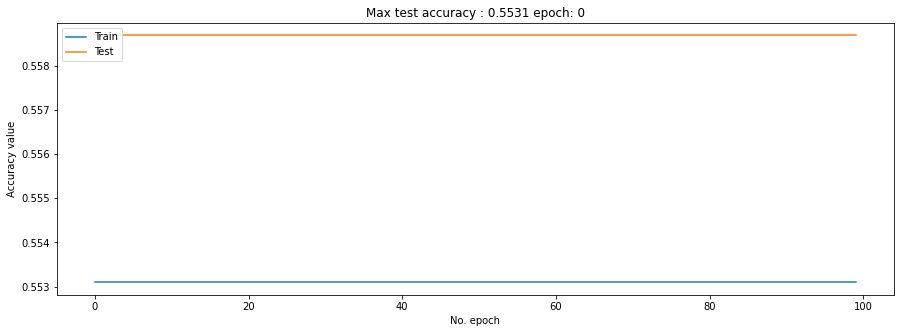

In [40]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Max test accuracy : %.4f epoch: %s' % (np.max((history.history['accuracy'])), np.argmax(history.history['val_accuracy'])))
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()